# Demo: Adding Jitter

This tutorial demonstrates how to add jitter to a **corgisim** simulation by including an additional dictionary when setting up the optics.

In [13]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from corgisim import scene, instrument, inputs, observation, jitter
from corgisim.scene import SimulatedImage
import proper
import roman_preflight_proper
roman_preflight_proper.copy_here()

In [14]:
from importlib import reload
reload(jitter)

<module 'corgisim.jitter' from '/Users/jessicag/Documents/GitHub/Dev/corgisim/corgisim/jitter.py'>

## Step 1: Define the astrophysical scene

The first step is to define the host star properties. For this example, we will model the host star as a point source.

In [15]:
# Define the host star properties
Vmag = 8
sptype = 'G0V'

host_star_properties = {'Vmag':Vmag, 'spectral_type': sptype, 'magtype':'vegamag'}

The next step is to define any companions. For this example, we will not include any companions.

Next, we set up the Scene object.

In [16]:
base_scene = scene.Scene(host_star_properties)

## Step 2: Define the optics 

The optics keywords are set up as usual. Currently, the finite stellar diameter option is not available for spectroscopy.

In [17]:
# Set up the optics keywords
cgi_mode = 'excam'
bandpass_corgisim = '1F'
cor_type = 'hlc_band1'
cases = ['3e-8']
rootname = 'hlc_ni_' + cases[0]
dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )

optics_keywords ={'cor_type':cor_type, 'use_errors':1, 'polaxis':10, 'output_dim':201,\
                  'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1,\
                  'use_lyot_stop':1,  'use_field_stop':1 }

An additional dictionary, stellar_diam_and_jitter_keywords, is needed to provide the parameters for the jitter model and to specify that this model should be used. Without this dictionary, corgisim will default to a jitter-free simulation.

This dictionary must contain the key-value pair 'add_jitter':1 for a simulation that includes jitter. Otherwise, **corgisim** will default to a jitter-free case. 

Jitter is modeled by defining a set of offset sources in addition to the on-axis point source, weighting the intensity contribution from each of these sources, and combining the weighted intensities. The offset source distribution in **corgisim** is built from concentric rings of offset sources, and it is defined by the following six parameters:

1. **N_rings_of_offsets**: The number of rings of offset sources, not counting the 0th ring containing only the on-axis source
2. **N_offsets_per_ring**: An array containing the number of offset sources in each ring of the distribution, excluding the 0th ring
3. **starting_offset_ang_by_ring**: An array containing the angle in degrees that places the first offset source in each ring, excluding the 0th ring
4. **r_ring0**: The radius in mas of the 0th ring, which contains the on-axis source
5. **dr_rings**: An array or scalar defining the width of each ring in the distribution, excluding the 0th ring.
                 If dr_rings is a scalar, all rings past the 0th are assigned the same width.
6. **outer_radius_of_offset_circle**: The outer radius in mas of the offset circle.

The first three parameters are required when defining a custom offset distribution. The last three parameters are optional in the sense that default values have been defined.

If outer_radius_of_offset_circle is not defined and if jitter is not being considered, outer_radius_of_offset_circle defaults to the radius of the star.

If r_ring0 is not defined, it defaults to 0.075 mas.

If dr_rings is not defined, it defaults to (outer_radius_of_offset_circle - r_ring0) / N_rings_of_offsets.

The jitter model also requires the root-mean-square (RMS) jitter in mas in the x and y directions.

For this example, we will use an offset source distribution that extends out to 6.475 mas and contains 124 offsets in 11 rings in addition to the on-axis source in the 0th ring. We will also assume that the RMS jitter is 0.3172369069947508 mas in the x direction and 0.3080179283580678 mas in the y direction.

In [18]:
# Set up the dictionary containing the jitter model parameters
stellar_diam_and_jitter_keywords = {'add_jitter':1,'jitter_sigmax':0.3172369069947508,'jitter_sigmay':0.3080179283580678,\
                                    'N_rings_of_offsets':11,'N_offsets_per_ring':np.array([6,8,12,14,12,10,14,10,14,10,14]),\
                                    'starting_offset_ang_by_ring':np.array([90,0,45,0,45,0,90,0,90,0,90]),'r_ring0':0.075,\
                                    'dr_rings':np.array([0.15,0.15,0.15,0.15,0.2,0.4,0.4,0.8,0.8,1.6,1.6]),\
                                    'outer_radius_of_offset_circle':6.475}

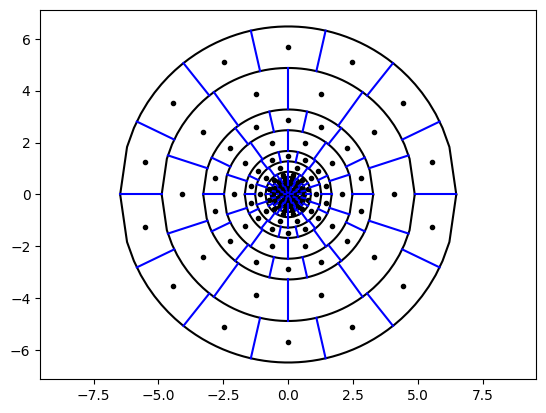

In [19]:
# Optional: Plotting the distribution of offset sources and the region represented by each

# Step 1: Use jitter.Determine_offsets_and_areas to calculate the set of offset source locations 
#         and sets of coordinates that define the boundaries of the regions represented by each source
x_offsets, y_offsets, A_offsets, x_outer_dict, yu_outer_dict, yl_outer_dict, boundary_coords_dict = \
jitter.Determine_offsets_and_areas(stellar_diam_and_jitter_keywords['outer_radius_of_offset_circle'],\
                                   stellar_diam_and_jitter_keywords['N_rings_of_offsets'], \
                                   stellar_diam_and_jitter_keywords['N_offsets_per_ring'],\
                                   stellar_diam_and_jitter_keywords['starting_offset_ang_by_ring'],\
                                   stellar_diam_and_jitter_keywords['r_ring0'],\
                                   stellar_diam_and_jitter_keywords['dr_rings'])

# Step 2: Use jitter.Plot_ALL_Offsets_And_Region_Outlines to draw the figure
jitter.Plot_ALL_Offsets_And_Region_Outlines(x_offsets,y_offsets,x_outer_dict,\
                                            yu_outer_dict,yl_outer_dict,\
                                            boundary_coords_dict,\
                                            stellar_diam_and_jitter_keywords['N_rings_of_offsets'],\
                                            stellar_diam_and_jitter_keywords['N_offsets_per_ring'])

The stellar_diam_and_jitter_keywords dictionary is used when setting up the optics. It must be included in this step, or **corgisim** will default to a jitter-free case.

In [20]:
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, optics_keywords=optics_keywords,\
                                stellar_diam_and_jitter_keywords=stellar_diam_and_jitter_keywords, if_quiet=True)

CorgiOptics initialized with proper keywords.


From this point on, the steps are the same as in other tutorials.

## Step 3: Simulate the image on the detector

In [21]:
# emccd keywords
gain = 1000
emccd_keywords = {'em_gain':gain}

# Set up the detector
detector = instrument.CorgiDetector(emccd_keywords)

# Define the exposure time
exp_time = 2000

# Test a single frame (Note that this step takes a bit of time because corgisim propagates each offset source in addition to the on-axis source.)
n_frames = 1
simulatedImage_list = observation.generate_observation_sequence(base_scene,optics,detector,exp_time,n_frames)

In [22]:
optics.stellar_diam_and_jitter_keywords.keys()


dict_keys(['add_jitter', 'jitter_sigmax', 'jitter_sigmay', 'N_rings_of_offsets', 'N_offsets_per_ring', 'starting_offset_ang_by_ring', 'r_ring0', 'dr_rings', 'outer_radius_of_offset_circle', 'use_finite_stellar_diam'])